In [1]:
import numpy as np
from scipy import signal, interpolate
import quaternion
import itertools

import matplotlib.pyplot as plt

from copy import copy

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from test_imu_algorithms import IMU_test_data

Set up test data from 0 to 50 seconds at 200Hz

In [4]:
pitchvals = [0, 5, 15]        # degrees of pitch
accelvals = [0, 0.05, 0.15]   # meters of forward-back motion
frequencies = [1,]     # Hz
phaseoff = [0, 0.2, 0.5]      # fractional phase offset between pitch and acceleration
chip_orient = [(-85, 82, 0)]       # initial roll, pitch, yaw of chip

All combinations of the parameters, but same noise settings

In [10]:
imus = []
params = []
for p, a, f, d, o in itertools.product(pitchvals, accelvals, frequencies, phaseoff, chip_orient):
    print "pitch {}, accel {}, freq {}, delta {}, orient {}".format(p,a,f,d,o)
    imu1 = IMU_test_data((0, 50, 1.0/200))
    R0 = imu1._eul2rotm(o)
    imu1.set_initial_orientation(R0)
    
    imu1.set_noise_params(gyrorms=1.0,          # deg/sec
                     gyrofreq=20.0,        # Hz
                     gyrodriftrms=0.0,     # deg/sec
                     gyrodriftfreq=0.1,    # Hz
                     accrms=0.03,          # g
                     accfreq=33)           # Hz
    imu1.generate_arm_data(alpham=np.deg2rad(p), # pitch angle
                      Am=a, # back and forth amplitude
                      f=f, # oscillation frequency
                      l=0.4,    # arm length
                      delta=d) # phase lag between angle and forward back motion
    
    imus.append(imu1)
    params.append((p,a,f,d,o))

pitch 0, accel 0, freq 1, delta 0, orient (-85, 82, 0)


pitch 0, accel 0, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 0, accel 0, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 0, accel 0.05, freq 1, delta 0, orient (-85, 82, 0)


pitch 0, accel 0.05, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 0, accel 0.05, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 0, accel 0.15, freq 1, delta 0, orient (-85, 82, 0)


pitch 0, accel 0.15, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 0, accel 0.15, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 5, accel 0, freq 1, delta 0, orient (-85, 82, 0)


pitch 5, accel 0, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 5, accel 0, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 5, accel 0.05, freq 1, delta 0, orient (-85, 82, 0)


pitch 5, accel 0.05, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 5, accel 0.05, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 5, accel 0.15, freq 1, delta 0, orient (-85, 82, 0)


pitch 5, accel 0.15, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 5, accel 0.15, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 15, accel 0, freq 1, delta 0, orient (-85, 82, 0)


pitch 15, accel 0, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 15, accel 0, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 15, accel 0.05, freq 1, delta 0, orient (-85, 82, 0)


pitch 15, accel 0.05, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 15, accel 0.05, freq 1, delta 0.5, orient (-85, 82, 0)


pitch 15, accel 0.15, freq 1, delta 0, orient (-85, 82, 0)


pitch 15, accel 0.15, freq 1, delta 0.2, orient (-85, 82, 0)


pitch 15, accel 0.15, freq 1, delta 0.5, orient (-85, 82, 0)


In [11]:
def get_error(imu):
    oerr = np.sqrt(np.mean(np.square(imu.orient_world - imu.orient_world_true), axis=0))
    aerr = np.sqrt(np.mean(np.square(imu.accdyn_world - imu.accdyn_world_true), axis=0))
    
    return oerr, aerr

In [14]:
orient = []
accdyn = []
orient_err = []
acc_err = []

for i, imu1 in enumerate(imus):
    # EKF
    imu1.filter(nsamp=10, method='running')

    imu1.calibrate(duration=30.0)
    imu1.get_inertial_coords(duration=30.0)
    imu1.get_world_coordinates(duration=30.0)
    
    imu1.get_orientation(method='ekf', Ca=(1.0, 1.0, 1.0))
    orient1 = copy(imu1.orient_world)
    accdyn1 = copy(imu1.accdyn_world)

    oerr1, aerr1 = get_error(imu1)
    
    # Madgwick
    imu1.filter(method='butter', order=5, gyro_cutoff=(0.1, 10), acc_cutoff=(0, 30))
    imu1.get_orientation(method='madgwick')
    orient2 = copy(imu1.orient_world)
    accdyn2 = copy(imu1.accdyn_world)
    
    oerr2, aerr2 = get_error(imu1)

    orient.append([orient1, orient2])
    accdyn.append([accdyn1, accdyn2])
    orient_err.append([oerr1, oerr2])
    acc_err.append([aerr1, aerr2])
    print "{} of {} ({}%)".format(i+1, len(imus), round(float(i+1)/len(imus)*100))

dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


1 of 27 (4.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


2 of 27 (7.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


3 of 27 (11.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


4 of 27 (15.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


5 of 27 (19.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


6 of 27 (22.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


7 of 27 (26.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


8 of 27 (30.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


9 of 27 (33.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


10 of 27 (37.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


11 of 27 (41.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


12 of 27 (44.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


13 of 27 (48.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


14 of 27 (52.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


15 of 27 (56.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


16 of 27 (59.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


17 of 27 (63.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


18 of 27 (67.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


19 of 27 (70.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


20 of 27 (74.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


21 of 27 (78.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


22 of 27 (81.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


23 of 27 (85.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


24 of 27 (89.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


25 of 27 (93.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


26 of 27 (96.0%)


dt=0.005, dur=10.0, N=10000, n=2000, nblocks=5
nblocks=5, ymn.shape=(7, 3)


27 of 27 (100.0%)


In [18]:
orient_err = np.array(orient_err)
acc_err = np.array(acc_err)

In [21]:
total_orient_err = np.sum(orient_err, axis=2)
total_acc_err = np.sum(acc_err, axis=2)

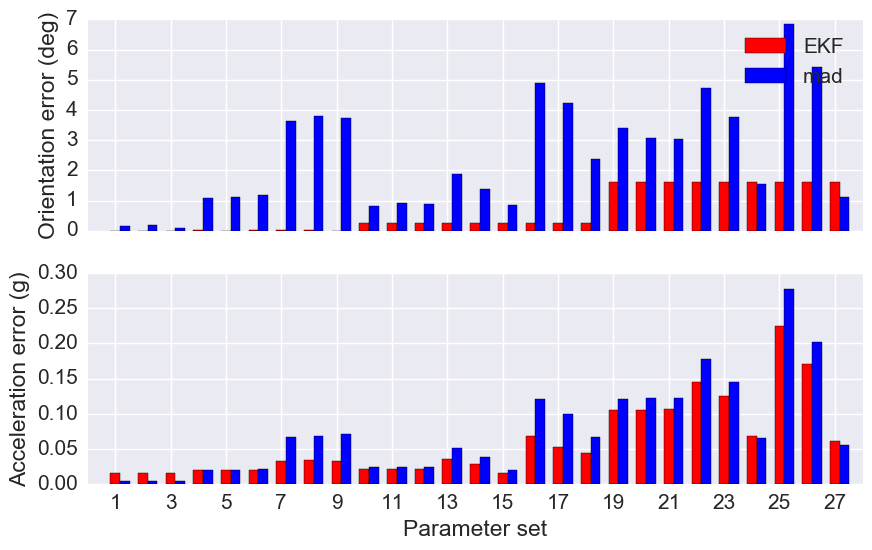

In [26]:
fig, ax = plt.subplots(2,1, sharex=True)

width = 0.35

ind = np.arange(len(imus))+1
ax[0].bar(ind-width/2, np.rad2deg(total_orient_err[:,0]), width=width, color='r', label='EKF')
ax[0].bar(ind+width/2, np.rad2deg(total_orient_err[:,1]), width=width, color='b', label='mad')
ax[0].set_ylabel('Orientation error (deg)')
ax[0].legend()

ax[1].bar(ind-width/2, total_acc_err[:,0], width=width, color='r', label='EKF')
ax[1].bar(ind+width/2, total_acc_err[:,1], width=width, color='b', label='mad')
ax[1].set_ylabel('Acceleration error (g)')

ax[1].set_xlabel('Parameter set')
ax[1].set_xticks(ind[::2])
ax[1].set_xlim([0, len(imus)+1])

plt.show()